# Title

In [1]:
import warnings

import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

The [orignal paper](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1475-4932.2012.00809.x) did not give any details on model selection that let us think that maybe the model chosen enhanced the results and showed that trends data had added value. No particular attention was given to timeseries specifics, as we know one have to be very careful when dealing with timeseries (stationarity problems) and model selection.

The following notebook will explore the timeseries structure and model selection rigourously.

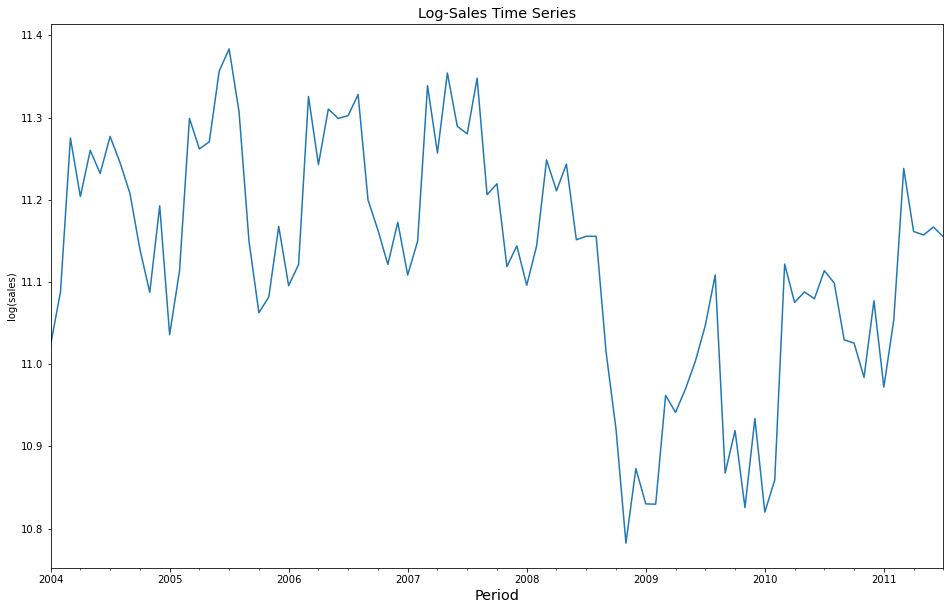

In [2]:
# Loading and processing data
df = pd.read_csv("./merged_autos.csv", parse_dates=["Period"], index_col="Period")
# log transform the data
df["sales"] = np.log(df["sales"])
df["log_sales"] = df["sales"]
axes = df["sales"].plot(figsize=(16, 10))
_ = axes.set_xlabel("Period", fontsize="x-large")
_ = axes.set_ylabel("log(sales)")
_ = axes.set_title("Log-Sales Time Series", fontsize="x-large")

Plotting the sales timeseries shows that it is not stationary, let us use an Augmented Dickey-Fuller test to verify this statement. The null hypothesis of the ADF test is non-stationarity.

In [3]:
adf_result = adfuller(df["sales"])
print("ADF Statistic: %f" % adf_result[0])
print("p-value: %f" % adf_result[1])

ADF Statistic: -1.740847
p-value: 0.410199


We faileld to reject the null hypothesis, meaning we failed to reject non stationarity. We will try to make the timeseries stationary in order to build an AR overall model. We will modify the timeserie as `log(S(t)/S(t-1))`

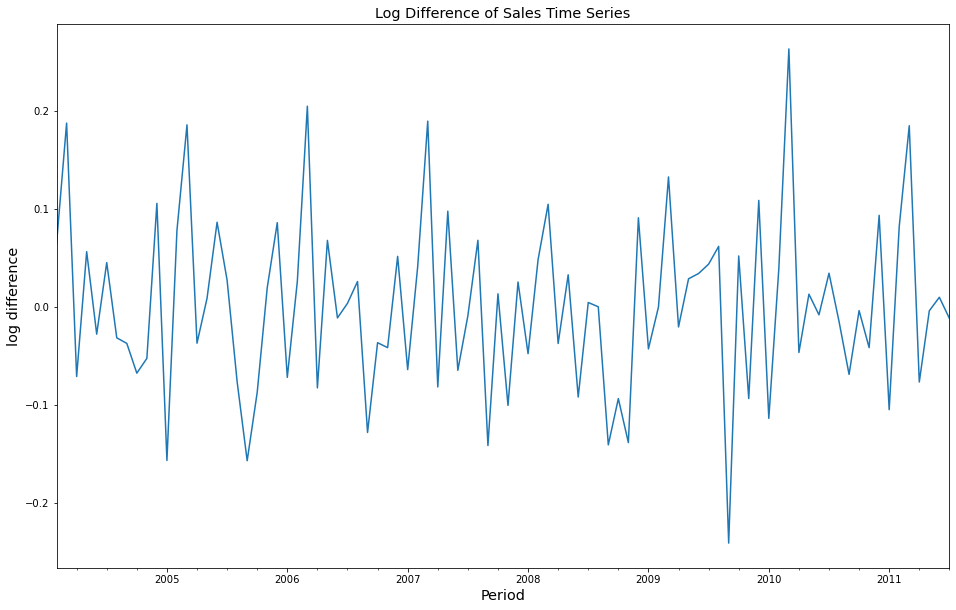

In [4]:
# compute log difference to stationarize the timeserie
df["sales"] = df["sales"] - df["sales"].shift(1)
df["suvs"] = df["suvs"] - df["suvs"].shift(1)
df["insurance"] = df["insurance"] - df["insurance"].shift(1)
# dropping null rows
df.dropna(inplace=True)
axes = df["sales"].plot(figsize=(16, 10))
_ = axes.set_xlabel("Period", fontsize="x-large")
_ = axes.set_ylabel("log difference", fontsize="x-large")
_ = axes.set_title("Log Difference of Sales Time Series", fontsize="x-large")

The time series looks stationary on different periods: from 2004 to 2008 and from 2008 to 2014. It does not look stationary in the whole period as the standard deviation seems to change between the 2 periods. Let us confirm our observations by using the Augmented Dickey-Fuller test.

In [5]:
adf_result = adfuller(df["sales"])
print("ADF Statistic all period: %f" % adf_result[0])
print("p-value all period: %f" % adf_result[1])

ADF Statistic all period: -1.788685
p-value all period: 0.386093


As described earlier, we fail to reject the non-stationarity on all the period but we notice that the pvalue is now smaller when calculating the log difference

In [6]:
period_delimiter = "04-01-2008"  # date of separation
# ADF test for the first period
adf_result_period1 = adfuller(df.loc[df.index <= period_delimiter, "sales"])
# ADF test for the second period
adf_result_period2 = adfuller(df.loc[df.index > period_delimiter, "sales"])

print("ADF Statistic up to " + period_delimiter + ": %f" % adf_result_period1[0])
print("p-value up to " + period_delimiter + ": %f" % adf_result_period1[1])
print("\n")
print("ADF Statistic from " + period_delimiter + ": %f" % adf_result_period2[0])
print("p-value from " + period_delimiter + ": %f" % adf_result_period2[1])

ADF Statistic up to 04-01-2008: -6.675553
p-value up to 04-01-2008: 0.000000


ADF Statistic from 04-01-2008: -4.859335
p-value from 04-01-2008: 0.000042


We can see that by delimiting in 04-01-2008, we have 2 time series that are stationary. Since we are trying to build an AR model we are going to be interested in the partial autocorelation function. The PACF plot will enable us to identify which lags are present in the underlying model.

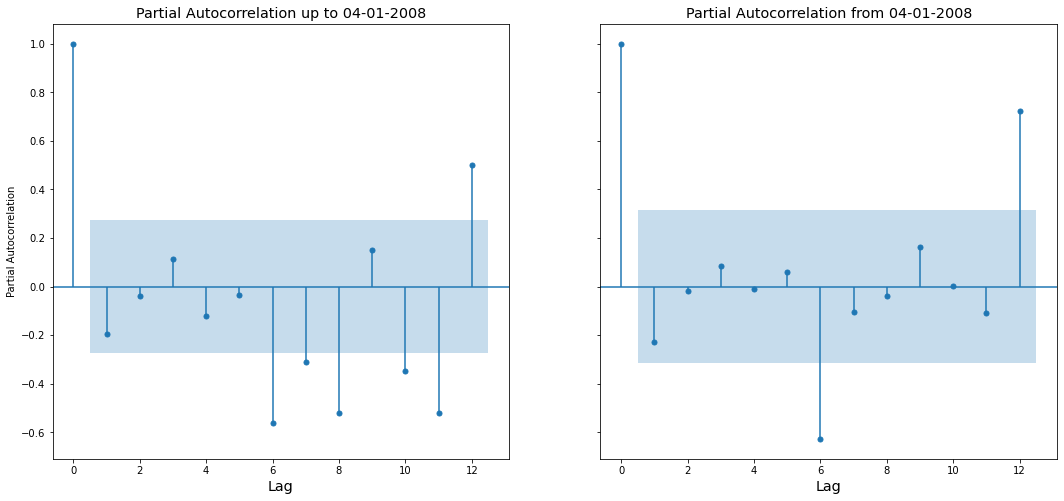

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

plot_pacf(
    df.loc[df.index <= period_delimiter, "sales"],
    lags=12,
    ax=axs[0],
)
plot_pacf(
    df.loc[df.index > period_delimiter, "sales"],
    lags=12,
    ax=axs[1],
)
axs[0].set_xlabel("Lag", fontsize="x-large")
axs[1].set_xlabel("Lag", fontsize="x-large")
axs[0].set_ylabel("Partial Autocorrelation")
axs[0].set_title(
    "Partial Autocorrelation up to " + period_delimiter, fontsize="x-large"
)
axs[1].set_title("Partial Autocorrelation from " + period_delimiter, fontsize="x-large")
plt.show()

Both periods shows significance for lags 6 and 12. The first period has more lags that are signification:7,8,10 and 11. The choice of lag 12 was a good choice in the paper. In order to be consistent with the rolling model of the paper (fitting one rolling model), we are going to choose the lags that are significant in both periods (6 and 12).

Let us fit an AR model for both periods and analyse the fit.


In [8]:
# Fitting AR model with lags 6 and 12 for the first period
lags_period_1 = [6, 12]
AR_endo_period_1 = AutoReg(
    endog=df.loc[df.index <= period_delimiter, "sales"], lags=lags_period_1
).fit()
AR_endo_period_1.summary()

/home/tariq/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/tariq/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                   51
Model:             Restr. AutoReg(12)   Log Likelihood                  63.916
Method:               Conditional MLE   S.D. of innovations              0.047
Date:                Fri, 18 Dec 2020   AIC                             -5.910
Time:                        01:04:04   BIC                             -5.740
Sample:                    02-01-2005   HQIC                            -5.849
                         - 04-01-2008                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.035e-05      0.008     -0.004      0.997      -0.015       0.015
sales.L6      -0.1571      0.096     -1.637      0.102      -0.345       0.031
sales.L12      0.7155      0.094      7.576      0.000       0.530       0.901
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0443           -0.0000j            1.0443           -0.5000
AR.2            -0.8769           -0.5063j            1.0125           -0.4167
AR.3            -0.8769           +0.5063j            1.0125            0.4167
AR.4            -0.5222           -0.9044j            1.0443           -0.3333
AR.5            -0.5222           +0.9044j            1.0443            0.3333
AR.6             0.0000           -1.0125j            1.0125           -0.2500
AR.7             0.0000           +1.0125j            1.0125            0.2500
AR.8             0.5222           -0.9044j            1.0443           -0.1667
AR.9             0.5222           +0.9044j            1.0443            0.1667
AR.10            1.0443           -0.0000j            1.0443           -0.0000
AR.11            0.8769           -0.5063j            1.0125           -0.0833
AR.12            0.8769           +0.5063j            1.0125            0.0833
------------------------------------------------------------------------------
"""

In [9]:
# Fitting AR model with lags 6 and 12 for the second period
lags_period_2 = [6, 12]
AR_endo_period_2 = AutoReg(
    endog=df.loc[df.index > period_delimiter, "sales"], lags=lags_period_2
).fit()
AR_endo_period_2.summary()

/home/tariq/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/tariq/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  sales   No. Observations:                   39
Model:             Restr. AutoReg(12)   Log Likelihood                  36.484
Method:               Conditional MLE   S.D. of innovations              0.063
Date:                Fri, 18 Dec 2020   AIC                             -5.244
Time:                        01:04:04   BIC                             -5.052
Sample:                    05-01-2009   HQIC                            -5.187
                         - 07-01-2011                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0105      0.012      0.867      0.386      -0.013       0.034
sales.L6      -0.1803      0.162     -1.111      0.266      -0.498       0.138
sales.L12      0.6122      0.159      3.860      0.000       0.301       0.923
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0619           -0.0000j            1.0619           -0.5000
AR.2            -0.8851           -0.5110j            1.0220           -0.4167
AR.3            -0.8851           +0.5110j            1.0220            0.4167
AR.4            -0.5309           -0.9196j            1.0619           -0.3333
AR.5            -0.5309           +0.9196j            1.0619            0.3333
AR.6            -0.0000           -1.0220j            1.0220           -0.2500
AR.7            -0.0000           +1.0220j            1.0220            0.2500
AR.8             0.5309           -0.9196j            1.0619           -0.1667
AR.9             0.5309           +0.9196j            1.0619            0.1667
AR.10            1.0619           -0.0000j            1.0619           -0.0000
AR.11            0.8851           -0.5110j            1.0220           -0.0833
AR.12            0.8851           +0.5110j            1.0220            0.0833
------------------------------------------------------------------------------
"""

The lags choosen shows statistical significance except for lag 6 in the second period (pvalue=0.266). Our Baseline Model is satsifying up to now. Let us add Trends data and verify its statistical significance

In [10]:
# Fitting AR model with lags 6,12 and trends for all the sample
lags_period_all = [6, 12]
AR_endo_period_all = AutoReg(
    endog=df["sales"], lags=lags_period_all, exog=df[["suvs", "insurance"]]
).fit()
AR_endo_period_all.summary()

/home/tariq/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/tariq/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                              
================================================================================
Dep. Variable:                    sales   No. Observations:                   90
Model:             Restr. AutoReg-X(12)   Log Likelihood                 124.701
Method:                 Conditional MLE   S.D. of innovations              0.049
Date:                  Fri, 18 Dec 2020   AIC                             -5.881
Time:                          01:04:04   BIC                             -5.700
Sample:                      02-01-2005   HQIC                            -5.809
                           - 07-01-2011                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0005      0.006     -0.086      0.931      -0.011       0.010
sales.L6      -0.1731      0.076     -2.289      0.022      -0.321      -0.025
sales.L12      0.6927      0.073      9.477      0.000       0.549       0.836
suvs           0.5545      0.139      3.999      0.000       0.283       0.826
insurance     -0.2083      0.092     -2.262      0.024      -0.389      -0.028
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0491           -0.0000j            1.0491           -0.5000
AR.2            -0.8776           -0.5067j            1.0134           -0.4167
AR.3            -0.8776           +0.5067j            1.0134            0.4167
AR.4            -0.5245           -0.9085j            1.0491           -0.3333
AR.5            -0.5245           +0.9085j            1.0491            0.3333
AR.6             0.0000           -1.0134j            1.0134           -0.2500
AR.7             0.0000           +1.0134j            1.0134            0.2500
AR.8             0.5245           -0.9085j            1.0491           -0.1667
AR.9             0.5245           +0.9085j            1.0491            0.1667
AR.10            1.0491           -0.0000j            1.0491           -0.0000
AR.11            0.8776           -0.5067j            1.0134           -0.0833
AR.12            0.8776           +0.5067j            1.0134            0.0833
------------------------------------------------------------------------------
"""

Google trends data shows significance as the pvalues are small. We can now proceed to fitting the rolling model to see if our baseline model improved the MAE and if adding trends data shows any further improvement.

In [11]:
# Adding shift for outsample rolling predictions calculations

for i in np.arange(1, 13, 1):
    df["sales_" + str(i)] = df["sales"].shift(i)
df["intercept"] = 1

# Functions calculating rolling AR out_sample predictions
# Base Model
def rolling_AR_endo(df, window, lags=[1, 12]):
    results = []
    regressor_names = ["intercept"] + ["sales_" + str(i) for i in lags]
    #     regressor_names =  ['intercept','sales_1','sales_12']
    for i in np.arange(window, len(df)):
        df_training = df.iloc[0:i]
        outsample = df.iloc[i]

        result_fit = AutoReg(endog=df_training["sales"], lags=lags).fit()
        result_pred = np.sum(
            np.array(result_fit.params) * np.array(outsample[regressor_names])
        )
        result_pred = result_pred + df_training.iloc[-1]["log_sales"]
        results.append(result_pred)
    return results


# Trends model
def rolling_AR_exo(
    df, window, lags=[1, 12], exogenous_regressors=["suvs", "insurance"]
):
    results = []
    regressor_names = (
        ["intercept"] + ["sales_" + str(i) for i in lags] + exogenous_regressors
    )
    #     exogenous_regressors=["suvs", "insurance"]

    for i in np.arange(window, len(df)):
        df_training = df.iloc[0:i]
        outsample = df.iloc[i]

        result_fit = AutoReg(
            endog=df_training["sales"],
            lags=lags,
            exog=df_training[exogenous_regressors],
        ).fit()
        result_pred = np.sum(
            np.array(result_fit.params) * np.array(outsample[regressor_names])
        )
        result_pred = result_pred + df_training.iloc[-1]["log_sales"]
        results.append(result_pred)
    return results

In [12]:
warnings.filterwarnings("ignore")

selected_lags = [6, 12]
# Outsample AutoReg for the base model
df.loc[df.index >= "2005-07-01", "Baseline_Predictions"] = rolling_AR_endo(
    df, 17, lags=selected_lags
)

# Autoreg cannot be fitted for the first iteration hence we use k=18 and replace the first prediction by the baseline
df.loc[df.index >= "2005-08-01", "Trends_Predictions"] = rolling_AR_exo(
    df, 18, lags=selected_lags
)
df.loc["2005-07-01", "Trends_Predictions"] = df.loc[
    "2005-07-01", "Baseline_Predictions"
]
# Keeping only the dates where we have predictions
df_results = df[df.index >= "2005-07-01"]

# Calculating MAE
baseline_mae = mean_absolute_error(
    df_results["log_sales"], df_results["Baseline_Predictions"]
)
trends_mae = mean_absolute_error(
    df_results["log_sales"], df_results["Trends_Predictions"]
)
improvement = (baseline_mae - trends_mae) / baseline_mae


print(f"MAE of the baseline model: {baseline_mae*100:.2f}%")
print(f"MAE of the trends model: {trends_mae*100:.2f}%")
print(f"MAE improvement: {improvement*100:.2f}%")

MAE of the baseline model: 4.75%
MAE of the trends model: 4.30%
MAE improvement: 9.47%


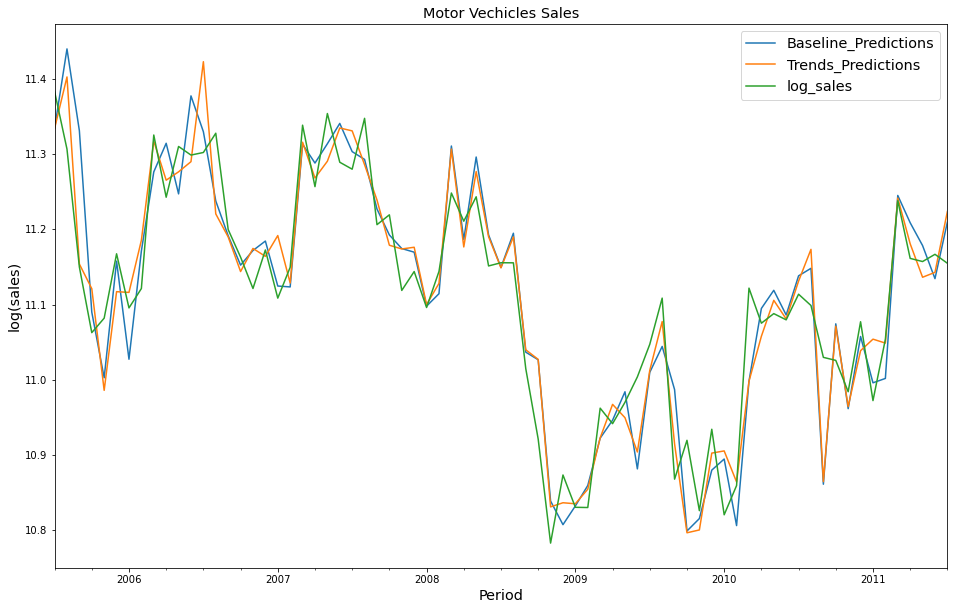

In [13]:
axes = df.loc[
    df.index >= "2005-07-01",
    ["Baseline_Predictions", "Trends_Predictions", "log_sales"],
].plot(figsize=(16, 10))
_ = axes.set_xlabel("Period", fontsize="x-large")
_ = axes.set_ylabel("log(sales)", fontsize="x-large")
_ = axes.set_title("Motor Vechicles Sales", fontsize="x-large")
_ = plt.legend(fontsize="x-large")

The new baseline model improved the outsample predictions. In the paper the MAE was 6.34% and with our rigourously chosen model we have 4.75% (25% improvement, higher improvement than adding trends in the paper). We can clearly see that Trends data improves our predictions by 9.47% even after finding a better AR model. This shows that Trends have predictive power and that it is not redundant with the information contained in the sales timeserie.

In [14]:
# keeping results only for recession period
df_results_recession = df_results.loc[
    (df_results.index >= "2007-12-01") & (df_results.index <= "2009-06-01")
]

baseline_mae_recession = mean_absolute_error(
    df_results_recession["log_sales"], df_results_recession["Baseline_Predictions"]
)
trends_mae_recession = mean_absolute_error(
    df_results_recession["log_sales"], df_results_recession["Trends_Predictions"]
)
improvement_recession = (
    baseline_mae_recession - trends_mae_recession
) / baseline_mae_recession

print(f"MAE of the baseline model during recession: {baseline_mae_recession*100:.2f}%")
print(f"MAE of the trends model during recession: {trends_mae_recession*100:.2f}%")
print(f"MAE improvement during recession: {improvement_recession*100:.1f}%")

MAE of the baseline model during recession: 3.93%
MAE of the trends model during recession: 3.63%
MAE improvement during recession: 7.6%


The baseline model predicts even better during a recession! The paper shows that the improvement of trends data is higher during recessions, we found that the improvement is only 7.6% compared to the new baseline model. Still the result confirms that Trends data has predictive power on all periods. To confirm our results let us finally use the granger-causality test for detecting if there is instantaneous causality between sales, suvs and insurance. This test is relevant as we are interested in predicting the present.

In [15]:
def grangers_causality_matrix(
    X_train, variables, test="ssr_chi2test", verbose=False, maxlag=12
):
    """Outputs a matrix summarizing the Granger Causality
    test results
    """
    dataset = pd.DataFrame(
        np.zeros((len(variables), len(variables))), columns=variables, index=variables
    )
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(
                X_train[[r, c]], maxlag=maxlag, verbose=False
            )
            p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
            if verbose:
                print(f"Y = {r}, X = {c}, P Values = {p_values}")
            min_p_value = np.min(p_values)
            dataset.loc[r, c] = min_p_value
    dataset.columns = [var + "_x" for var in variables]
    dataset.index = [var + "_y" for var in variables]
    return dataset


grangers_causality_matrix(
    df[["sales", "suvs", "insurance"]], variables=["sales", "suvs", "insurance"]
)

,sales_x,suvs_x,insurance_x
sales_y,1.0,0.0000,0.0
suvs_y,0.0,1.0000,0.0
insurance_y,0.0,0.0007,1.0


In the Matrix we have pvalues of the Granger-causality test. The matrix is read this way: does suvs_x causes instantaneous movement of sales_y. We can see that we have pvalues of almost 0 for suvs and insurance on sales. This test enable us to reject the null hypothesis that there is no instantaneous causality of trends on sales.
Finally by building rigourously a better model and using Granger-causality test we can now affirm that Google trends data has predictive power.

## Predicting the futur with Google Trends

We're trying to asses if the google trends data has any futur predictive capibility. For this we'll construct a futur predicting model on the autos dataset using the same data as above and compare its performance to the baseline AR model above. We'll simply do that by lagging our Google Trend data to emulate a futur prediction.

In [16]:
df = pd.read_csv("./merged_autos.csv", parse_dates=["Period"], index_col="Period")
# log transform the data
df["log_sales"] = np.log(df["sales"])
df["sales"] = np.log(df["sales"])
# compute log difference to stationarize the timeserie
df["sales"] = df["sales"] - df["sales"].shift(1)
df["suvs"] = df["suvs"] - df["suvs"].shift(1)
df["insurance"] = df["insurance"] - df["insurance"].shift(1)

In [17]:
df["insurance.l1"] = df["insurance"].shift(1)
df["suvs.l1"] = df["suvs"].shift(1)
df["insurance.l2"] = df["insurance"].shift(2)
df["suvs.l2"] = df["suvs"].shift(2)
df["sales_6"], df["sales_12"] = df["sales"].shift(6), df["sales"].shift(12)
df["intercept"] = 1
df.dropna(inplace=True)

We'll strat by using the lags 1 and 2 of our two google trends data as exogenous variables

In [22]:
selected_lags = [6, 12]
AR_model = AutoReg(
    endog=df["sales"],
    lags=selected_lags,
    exog=df[
        [
            "insurance.l1",
            "suvs.l1",
            "insurance.l2",
            "suvs.l2",
        ]
    ],
).fit()
AR_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                              
================================================================================
Dep. Variable:                    sales   No. Observations:                   78
Model:             Restr. AutoReg-X(12)   Log Likelihood                 103.274
Method:                 Conditional MLE   S.D. of innovations              0.051
Date:                  Fri, 18 Dec 2020   AIC                             -5.725
Time:                          01:26:45   BIC                             -5.460
Sample:                      02-01-2006   HQIC                            -5.620
                           - 07-01-2011                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0015      0.006     -0.235      0.814      -0.014       0.011
sales.L6        -0.2241      0.094     -2.397      0.017      -0.407      -0.041
sales.L12        0.5369      0.101      5.312      0.000       0.339       0.735
insurance.l1     0.1848      0.122      1.518      0.129      -0.054       0.424
suvs.l1         -0.0659      0.169     -0.390      0.697      -0.397       0.265
insurance.l2     0.2529      0.134      1.884      0.060      -0.010       0.516
suvs.l2          0.0824      0.164      0.501      0.616      -0.240       0.405
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0803           -0.0000j            1.0803           -0.5000
AR.2            -0.8892           -0.5134j            1.0268           -0.4167
AR.3            -0.8892           +0.5134j            1.0268            0.4167
AR.4            -0.5401           -0.9356j            1.0803           -0.3333
AR.5            -0.5401           +0.9356j            1.0803            0.3333
AR.6             0.0000           -1.0268j            1.0268           -0.2500
AR.7             0.0000           +1.0268j            1.0268            0.2500
AR.8             0.5401           -0.9356j            1.0803           -0.1667
AR.9             0.5401           +0.9356j            1.0803            0.1667
AR.10            1.0803           -0.0000j            1.0803           -0.0000
AR.11            0.8892           -0.5134j            1.0268           -0.0833
AR.12            0.8892           +0.5134j            1.0268            0.0833
------------------------------------------------------------------------------
"""

We can see from this summary that the suv trend is not relevant to the model, so we'll take it out

In [24]:
selected_lags = [6, 12]
AR_model = AutoReg(
    endog=df["sales"],
    lags=selected_lags,
    exog=df[
        [
            "insurance.l1",
            "insurance.l2",
        ]
    ],
).fit()
AR_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             AutoReg Model Results                              
================================================================================
Dep. Variable:                    sales   No. Observations:                   78
Model:             Restr. AutoReg-X(12)   Log Likelihood                 103.008
Method:                 Conditional MLE   S.D. of innovations              0.051
Date:                  Fri, 18 Dec 2020   AIC                             -5.778
Time:                          01:31:06   BIC                             -5.578
Sample:                      02-01-2006   HQIC                            -5.699
                           - 07-01-2011                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0014      0.006     -0.222      0.824      -0.014       0.011
sales.L6        -0.2103      0.092     -2.289      0.022      -0.390      -0.030
sales.L12        0.5425      0.101      5.384      0.000       0.345       0.740
insurance.l1     0.1556      0.103      1.517      0.129      -0.045       0.357
insurance.l2     0.2698      0.121      2.237      0.025       0.033       0.506
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0775           -0.0000j            1.0775           -0.5000
AR.2            -0.8900           -0.5138j            1.0276           -0.4167
AR.3            -0.8900           +0.5138j            1.0276            0.4167
AR.4            -0.5388           -0.9332j            1.0775           -0.3333
AR.5            -0.5388           +0.9332j            1.0775            0.3333
AR.6            -0.0000           -1.0276j            1.0276           -0.2500
AR.7            -0.0000           +1.0276j            1.0276            0.2500
AR.8             0.5388           -0.9332j            1.0775           -0.1667
AR.9             0.5388           +0.9332j            1.0775            0.1667
AR.10            1.0775           -0.0000j            1.0775           -0.0000
AR.11            0.8900           -0.5138j            1.0276           -0.0833
AR.12            0.8900           +0.5138j            1.0276            0.0833
------------------------------------------------------------------------------
"""

Now it's the 1 lag of insurance that is not significant, we'll take it out for our out of sample prediction

In [28]:
warnings.filterwarnings("ignore")

# We'll keep the same lags as the baseline model
selected_lags = [6, 12]
df["trends_predictions"] = np.nan
# Outsample AutoReg for the base model
df.iloc[20:]["trends_predictions"] = rolling_AR_exo(
    df[
        [
            "log_sales",
            "sales_6",
            "sales_12",
            "intercept",
            "sales",
            "insurance.l2",
        ]
    ],
    20,
    lags=selected_lags,
    exogenous_regressors=[
        "insurance.l2",
    ],
)
trends_mae = np.mean(np.abs(df["log_sales"] - df["trends_predictions"]))
improvement = (baseline_mae - trends_mae) / baseline_mae

print(f"MAE of the baseline model: {baseline_mae*100:.2f}%")
print(f"MAE of the trends model: {trends_mae*100:.2f}%")
print(f"MAE improvement: {improvement*100:.2f}%")
# print(f"MAE improvement: {improvement*100:.2f}%")

MAE of the baseline model: 4.75%
MAE of the trends model: 4.22%
MAE improvement: 11.20%


We managed to build a model that incorporates google trends data and performs better than a simple AR model for futur prediction of auto sales. Next we'd like to test if Google Trends data can help in predicting the futur values of a more challenging economics TimeSeries: The VIX